In [2]:
#%run -i '../../scripts/utility_readblt.py' 'emu'

In [7]:
from utility_common import *
from utility_plotter import *
import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline

#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

# 1. Read data and MC as dataframe

In [2]:
selection  = "emu2"
pickledir  = "/mnt/data/zchen/Analysis/pickle/emu/"

In [3]:
def prepare_df_list(nbjetcut):

    cuts = GetSelectionCut(selection) + "& (nBJets{})".format(nbjetcut)

    Data = LoadDataframe(pickledir + "data2016").query(cuts)
    MCzz = LoadDataframe(pickledir + "mcdiboson").query(cuts)
    MCdy = LoadDataframe(pickledir + "mcdy").query(cuts)
    MCt  = LoadDataframe(pickledir + "mct").query(cuts)
    MCtt = LoadDataframe(pickledir + "mctt").query(cuts)

    Data = Data.drop_duplicates(subset=['runNumber', 'evtNumber'])

    # signal mc is tt+tW
    MCsg = pd.concat([MCt,MCtt],ignore_index=True)

    MCsgf = MCsg.query('(genCategory >= 16) ') # semilep and had
    MCsg0 = MCsg.query('genCategory in [1,2,4,5,6,7,8,9]') #other lep
    MCsg1 = MCsg.query('genCategory in [3]') #ee
    MCsg2 = MCsg.query('genCategory in [10,11,12]') #etau
    MCsg3 = MCsg.query('genCategory in [13,14,15]') #mutau


    return [MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,MCsg3,Data],MCt,MCtt

# 2. Plot kinematics

In [4]:
pp = pd.read_csv("plotparameters.csv")
label_list = ["Diboson","V+Jets",r'$tt/tW \rightarrow l + h$ (other)',
              r'$tt/tW \rightarrow l + l$ (other) ',
              r'$tt/tW \rightarrow e + \mu$', 
              r'$tt/tW \rightarrow e + \tau$',
              r'$tt/tW \rightarrow \mu + \tau$',
              'data']
color_list = ["#a32020","#e0301e","#eb8c00","gold","#49feec","deepskyblue","mediumpurple","k"]

In [7]:
for nbjetcut in ["==1",">1",">=1"]:
    df_list,_,__ = prepare_df_list(nbjetcut)
    plotoutdir = GetPlotDir(selection, nbjetcut)
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        
        plotter = SelectionPlotter(v,a,b,step,df_list)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)

        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

finish all making plots


# 3. Counting

In [5]:
nbjetcut = ">=1"
df_list,MCt,MCtt = prepare_df_list(nbjetcut)
ctr = SelectionCounter()

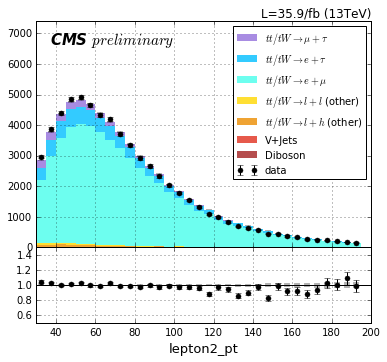

In [6]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton2_pt",30,200,5,"lepton2_pt"
plotter = SelectionPlotter(v,a,b,step,df_list)
plotter.settingPlot(xl,label_list,color_list,plotWithoutXsErr=False)
plotter.makePlot()

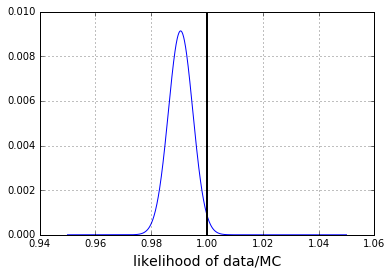

In [7]:
ratio = plotter.hdata/plotter.mctot
err   = sqrt((plotter.hdata**0.5/plotter.mctot)**2 + (plotter.mcerr/plotter.mctot)**2)


x = np.linspace(0.95,1.05,1000)
l = np.ones_like(x)
for i in range(len(ratio)):
    norm = (1/sqrt(2*np.pi*err[i]**2))
    l *= norm*np.exp(-(x-ratio[i])**2/(2*err[i]**2))
    #nll = nll+(x-ratio[i])**2/(2*err[i]**2)
l = l/np.sum(l)

plt.plot(x,l)
plt.xlabel("likelihood of data/MC",fontsize=14)
plt.axvline(1,c="k",lw=2)
plt.grid()

np.save("dataMCRatio/emu2_095to105", l)

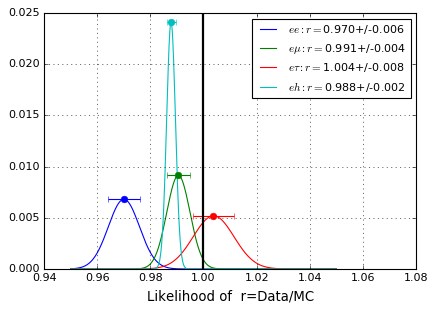

In [10]:
e = np.load("dataMCRatio/ee_095to105.npy")
m = np.load("dataMCRatio/emu2_095to105.npy")
t = np.load("dataMCRatio/etau_095to105.npy")
h = np.load("dataMCRatio/e4j_095to105.npy")

x = np.linspace(0.95,1.05,1000)

def center(arr,x):
    height = arr.max()
    halfHeight = height/np.exp(0.5)
    up = x[np.argmin(np.abs(arr-halfHeight))]
    c  = x[np.argmax(arr)]
    sigma = abs(c-up)
    return height,c,sigma
#e
prob,cent,sig = center(e,x)
plt.errorbar(cent,prob,xerr=sig,c="C0",marker="o",markeredgecolor="C0")
plt.plot(x,e,c="C0",label=r"$e e: r=$"+'{:4.3f}+/-{:4.3f}'.format(cent,sig) )
#mu
prob,cent,sig = center(m,x)
plt.errorbar(cent,prob,xerr=sig,c="C1",marker="o",markeredgecolor="C1")
plt.plot(x,m,c="C1",label=r"$e \mu: r=$"+'{:4.3f}+/-{:4.3f}'.format(cent,sig) )
#tau
prob,cent,sig = center(t,x)
plt.errorbar(cent,prob,xerr=sig,c="C2",marker="o",markeredgecolor="C2")
plt.plot(x,t,c="C2",label=r"$e \tau: r=$"+'{:4.3f}+/-{:4.3f}'.format(cent,sig) )
#h
prob,cent,sig = center(h,x)
plt.errorbar(cent,prob,xerr=sig,c="C3",marker="o",markeredgecolor="C3")
plt.plot(x,h,c="C3",label=r"$e h: r=$"+'{:4.3f}+/-{:4.3f}'.format(cent,sig) )

plt.xlabel(r'Likelihood of  r=Data/MC',fontsize=12)
plt.axvline(1,c="k",lw=2)
plt.legend(fontsize=10)
plt.grid()
plt.xlim(0.94,1.08)
plt.savefig("../../plot/etrigger_dataMC.png",dpi=300)

In [20]:
print("(nBJets{})".format(nbjetcut))

print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets>1)
MCtt: [10, 10, 117904, 0, 0, 638, 2, 8, 0, 3, 11766, 27, 6405, 1, 63, 332, 92, 16, 3, 0, 1]
MCtt width: [9.395845230221749, 9.756975795626639, 107296.7895445795, 0.0, 0.0, 554.8913809934054, 1.3629217514395713, 6.647220607697963, 0.0, 2.8545503866672517, 10535.884498179877, 22.21466142923804, 5740.719565972495, 1.0239040625095366, 55.27441760712303, 280.50051054207137, 82.07756150720643, 14.023197383768856, 2.9451511055231094, 0.0, 0.9432240778207778]
MCt : [0, 0, 477, 0, 0, 5, 0, 0, 0, 1, 43, 0, 41, 0, 0, 2, 0, 0, 0, 0, 0]
MCt width: [0.0, 0.0, 436.03973518269834, 0.0, 0.0, 4.664257885217666, 0.0, 0.0, 0.0, 0.9343631780147552, 40.96370512604713, 0.0, 36.52140059722588, 0.0, 0.0, 2.055162615776062, 0.0, 0.0, 0.0, 0.0, 0.0]


In [23]:
ctr.countSlt_Scaled(df_list)

data:4098.0
TotalMC:4122.418421078151
------ MC break down ------
[   3.55531594    6.6927005    43.7171013    46.42629043 2970.40461449
  902.66871627  148.95368215]


In [24]:
for thisdf in [df_list[0],df_list[1], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))
#mc,h = PlotHistogram("lepton2_pt",0,150,5,"lepton2_pt [GeV]", df_list,label_list,color_list)

3.56,1.77
6.69,2.09
112.69,11.79
3999.49,26.87
4098.00,64.02


In [25]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 418126.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5260.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]
